### 영화 리뷰를 사용한 텍스트 분류
영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류합니다. 이 예제는 이진(binary)-또는 클래스(class)가 두 개인- 분류 문제입니다. 이진 분류는 머신러닝에서 중요하고 널리 사용됩니다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.4.1


In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 2s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\chaeh\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\chaeh\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

In [3]:
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


In [5]:
#리뷰 텍스트는 어휘 사전의 특정 단어를 나타내는 정수로 변환되어 있습니다.
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
#영화 리뷰들은 길이가 다릅니다. 신경망의 입력은 길이가 같아야 하기 때문에 나중에 이 문제를 해결하겠습니다.
len(train_data[0]), len(train_data[1])

(218, 189)

#### 정수를 단어로 다시 변환하기

In [7]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [10]:
#길이가 모두 같도록 맞춰주는 함수
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [11]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

#### 모델 구성
신경망은 층(layer)을 쌓아서 만듭니다. 이 구조에서는 두 가지를 결정해야 합니다:

- 모델에서 얼마나 많은 층을 사용할 것인가?
- 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?

이 예제의 입력 데이터는 단어 인덱스의 배열입니다. 예측할 레이블은 0 또는 1입니다. 이 문제에 맞는 모델을 구성해 보겠습니다:



In [14]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다(10,000개의 단어)

vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


첫 번째 층은 Embedding 층입니다. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됩니다. 이 벡터는 출력 배열에 새로운 차원으로 추가됩니다. 최종 차원은 (batch, sequence, embedding)이 됩니다.

그다음 GlobalAveragePooling1D 층은 sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.

이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(Dense)을 거칩니다.

마지막 층은 하나의 출력 노드(node)를 가진 완전 연결 층입니다. sigmoid 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 검증 세트 만들기
모델을 훈련할 때 모델이 만난 적 없는 데이터에서 정확도를 확인하는 것이 좋습니다. 

In [16]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 모델 훈련

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 42ms/step - loss: 0.6929 - accuracy: 0.5253 - val_loss: 0.6913 - val_accuracy: 0.5922
Epoch 2/40
30/30 [==============================] - 1s 23ms/step - loss: 0.6902 - accuracy: 0.6604 - val_loss: 0.6862 - val_accuracy: 0.6779
Epoch 3/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6832 - accuracy: 0.7202 - val_loss: 0.6755 - val_accuracy: 0.7034
Epoch 4/40
30/30 [==============================] - 1s 24ms/step - loss: 0.6700 - accuracy: 0.7229 - val_loss: 0.6575 - val_accuracy: 0.7469
Epoch 5/40
30/30 [==============================] - 1s 23ms/step - loss: 0.6478 - accuracy: 0.7557 - val_loss: 0.6306 - val_accuracy: 0.7651
Epoch 6/40
30/30 [==============================] - 1s 23ms/step - loss: 0.6169 - accuracy: 0.7881 - val_loss: 0.5961 - val_accuracy: 0.7965
Epoch 7/40
30/30 [==============================] - 1s 23ms/step - loss: 0.5776 - accuracy: 0.8188 - val_loss: 0.5562 - val_accuracy: 0.8018
Epoch 8/40
30

In [20]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3187 - accuracy: 0.8737
[0.31866636872291565, 0.8736799955368042]


verbose뜻

0 = silent, 
1 = progress bar, 
2 = one line per epoch

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

- acc: 매 epoch 마다의 훈련 정확도

- loss: 매 epoch 마다의 훈련 손실 값

- val_acc: 매 epoch 마다의 검증 정확도

- val_loss: 매 epoch 마다의 검증 손실 값

훈련과 검증 단계에서 모니터링하는 지표들입니다. 훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도도 그래프로 그려서 비교해 보겠습니다:

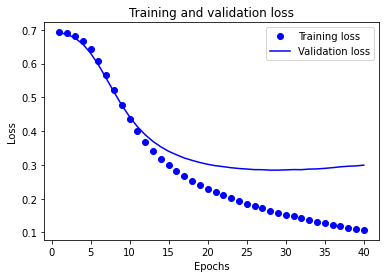

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

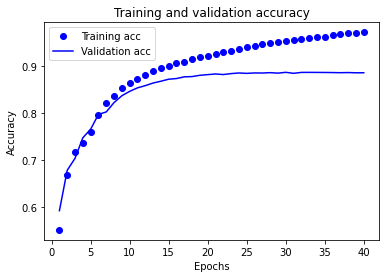

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

훈련 손실은 에포크마다 감소하고 훈련 정확도는 증가한다는 것을 주목하세요. 경사 하강법 최적화를 사용할 때 볼 수 있는 현상입니다. 매 반복마다 최적화 대상의 값을 최소화합니다.

하지만 검증 손실과 검증 정확도에서는 그렇지 못합니다. 약 20번째 에포크 이후가 최적점인 것 같습니다. 이는 과대적합 때문입니다. 이전에 본 적 없는 데이터보다 훈련 데이터에서 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 일반화되기 어려운 훈련 데이터의 특정 표현을 학습합니다.

여기에서는 과대적합을 막기 위해 단순히 20번째 에포크 근처에서 훈련을 멈출 수 있습니다.